In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Machine learning techniques

In this notebook we will explore some classic machine learning techniques. First lets dive into logistic regression, since it is closely related to neural network classifiers, and then we will give a shallower overview of some more complex algorithms

## Logistic regression:
For a linear regression problem, trying to output a continuous value.
For classification, trying to output a classification. If use a linear classifier, unbounded, and residuals are wrong 

Logistic classifier uses a sigmoid (logistic) function, i.e.
$$y = \text{sigmoid}(A x+ b)\\
y = \frac{1}{1 + e^{-(A x + b)}}$$

Therefore the output of the linear network gives the log likelihood ratio
$$e^{-(A x + b)} = (1-y)/y\\
A x + b = \log(y/1-y)$$
### MLE

Lets be a bit more scientific. What we want is to do is *Maximum Likelihood Estimation*

Given (noisy) data $\pmb{x}$ and labels y, we want to find a model $y' = f(\pmb{x}|\theta)$ parametrised by $\theta$ that maximises $p(\theta |y, \pmb{x})$. By Bayes, $p(\theta |y, \pmb{x}) = p(y |\pmb{x}, \theta) p(\theta) / p(y)$. Assuming that the data isn't special, $p(y)$ should be uniform. Lets also take a uniform prior for $\theta$. 

So what we want to maximise (dropping the uniform bits) is 
$$p(y |\pmb{x}, \theta) = \prod_i p(y_i |x_i,\theta)$$
Lets take the log likelihood:
$$ll = \log(p(y |\pmb{x}, \theta)) = \sum_i \log(p(y_i|x_i, \theta))$$

Since we are doing classification with binary labels, we find
$$\log(p(y_i |x_i, \theta)) = y_i \log(f(x_i, \theta)) + (1 - y_i)\log(1 - f(x_i, \theta)) $$
This is the *cross entropy* $H(y_i,f(x_i, \theta))$

And so 
$$ll = \log(p(y |\pmb{x}, \theta)) = \sum_i y_i \log(f(x_i, \theta)) + (1 - y_i)\log(1 - f(x_i, \theta))$$

Taking the derivative, which we want to set to zero ($\partial_\theta ll  = 0$):
$$\partial_\theta ll = \frac{\delta \log(p(y |\pmb{x}, \theta))}{\delta \theta} = \sum_i y_i f'(x_i, \theta) / f(x_i, \theta) - (1 - y_i)f'(x_i, \theta) / (1  - f(x_i, \theta))\\
= \sum_i y_i f'(x_i, \theta) / f(x_i, \theta) - (1 - y_i)f'(x_i, \theta) / (1  - f(x_i, \theta))$$

Using the identity
$$f'(z) = \delta_z \frac{1}{1 + e^{-z}}\\
= \frac{e^{-z}}{(1 + e^{-z})^2}\\
= \frac{1}{1 + e^{z}}\frac{1}{1 + e^{-z}}
= f(z) (1 - f(z))$$
we find that
$$\partial_\theta ll = \sum_i \delta_\theta(A \pmb{x_i}) (y_i f(x_i, \theta) (1 - f(x_i, \theta)) / f(x_i, \theta) - (1 - y_i)f(x_i, \theta) (1 - f(x_i, \theta)) / (1  - f(x_i, \theta)))\\
= \sum_i \delta_\theta(A \pmb{x_i}) (y_i (1 - f(x_i, \theta)) - (1 - y_i)f(x_i, \theta))\\
= \sum_i \delta_\theta(A \pmb{x_i}) (y_i - f(x_i, \theta))$$

Since in this case $\theta$ is $A$, this gives the function
$$\partial_\theta ll = \sum_i \pmb{x_i} (y_i - f(x_i, \theta))$$

Unfortunately, the equation $\sum_i \pmb{x_i} (y_i - f(x_i, \theta)) = 0$ cannot be solved in closed form. So off to the land of numerics. 

We still the cross entropy as our cost function to minimise, but now take steps in the direction of the derivative 
$\sum_i \pmb{x_i} (y_i - f(x_i, \theta))$


### Implementation

In [2]:
def logistic(x,A,b):
    if np.ndim(x) == 1:
        x = np.array([x])
    return 1/(1 + np.exp(np.dot(A,x.T) + b))

def cross_entropy(y,x,A,b):
    return -np.sum(y * np.log(logistic(x,A,b)) + (1- y) * np.log(1 - logistic(x,A,b)),axis=0)/x.shape[0]

def A_grad_cross_entropy(y,x,A,b):
    return np.dot(x.T,(y - logistic(x,A,b)))/x.shape[0]

def b_grad_cross_entropy(y,x,A,b):
    return np.mean(y - logistic(x,A,b),axis=0)

In [3]:
def coord_decision_line(A,b,x0):
    return -(A[0]*x0+b)/A[1] 
def plot_decision_line(A,b,x,linestyle='-'):
    min_max = (np.min(x,axis=0)[0], np.max(x,axis=0)[0])
    x_d = np.array([[i,coord_decision_line(A,b,i)] for i in np.linspace(min_max[0],min_max[1],100)])
    plt.plot(x_d[:,0],x_d[:,1],linestyle=linestyle)


In [41]:
def momentum_sgd(x,y):
    A = np.random.normal(size=x.shape[1])/np.sqrt(x.shape[0])
    b = 0
    steps = 5000
    alpha = 1e-2
    beta = 0.9
    gradA = 0
    gradb = 0
    for i in range(steps):
        gradA =  beta * gradA + (1-beta) * A_grad_cross_entropy(y,x,A,b)
        gradb =  beta * gradb + (1-beta) * b_grad_cross_entropy(y,x,A,b)
        A -= alpha * gradA
        b -= alpha * gradb
    return A,b,cross_entropy(y,x,A,b)


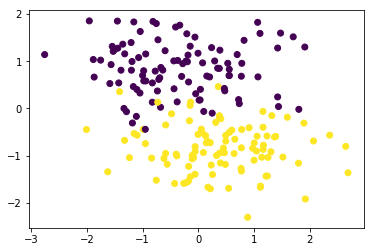

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
x, y = datasets.make_blobs(n_samples=200, centers=2, n_features=2, random_state=0,cluster_std=1.2)
x = StandardScaler().fit_transform(x) # Scale to unit variance, no mean
plt.scatter(x[:,0],x[:,1],c=y)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

In [43]:
def print_accs_logistic(x_train,x_test,y_train,y_test,A,b):
    test_acc = np.mean(y_test == (logistic(x_test,A,b)>0.5))
    train_acc = np.mean(y_train == (logistic(x_train,A,b)>0.5))
    print('Train acc. %0.1f %%' % (train_acc*100))
    print('Test acc. %0.1f %%' %(test_acc*100))

Cross entropy train 0.147992
Train acc. 94.4 %
Test acc. 95.0 %


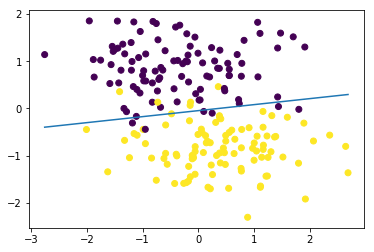

In [44]:
A,b,ce = momentum_sgd(x_train,y_train)
print('Cross entropy train %f' % ce)
print_accs_logistic(x_train,x_test,y_train,y_test,A,b)
plt.scatter(x[:,0],x[:,1],c=y)
plot_decision_line(A,b,x)

The algorithm works about as well as we can expect it to on this simple problem. 

Out of interest, can we do a bit better with bagging?


Average train cross entropy: 0.155921
Bagged cross entropy: 0.151456
Train acc. 95.0 %
Test acc. 92.5 %


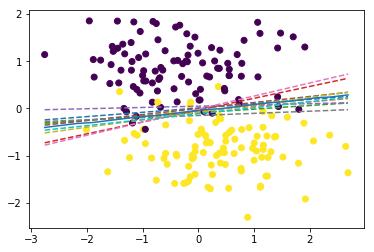

In [45]:
def bagged_pred(As,bs,x):
    return np.mean([logistic(x,Ai,bi) for Ai,bi in zip(As,bs)],axis=0)

def bagged_cross_entropy(y,x,As,bs):
    return -np.sum(y * np.log(bagged_pred(As,bs,x)) + (1- y) * np.log(1 - bagged_pred(As,bs,x)),axis=0)/x.shape[0]


size = 10
bagged_inds = np.random.randint(0,x_train.shape[0],(size,x_train.shape[0]))

plt.scatter(x[:,0],x[:,1],c=y)
As = []
bs = []
ces = []
for inds in bagged_inds:
    xt = x_train[inds]
    yt = y_train[inds]
    A,b,ce = momentum_sgd(xt,yt)
    As.append(A)
    bs.append(b)
    ces.append(ce)
    plot_decision_line(A,b,x,linestyle='--')
print("Average train cross entropy: %f" % np.mean(ces))
print("Bagged cross entropy: %f" %bagged_cross_entropy(y_train,x_train,As,bs))
print_accs_logistic(x_train,x_test,y_train,y_test,A,b)

y_dec_line = np.zeros((20))
ypreds = np.zeros((200))
x_min, x_max = x[:, 0].min(), x[:, 0].max()
y_min, y_max = x[:, 1].min(), x[:, 1].max()

xpoints = np.linspace(x_min,x_max,20)
ypoints = np.linspace(y_min,y_max,200)
for i,xp in enumerate(xpoints):
    for j,yp in enumerate(ypoints):
        ypreds[j] = bagged_pred(As,bs,[xp,yp])-0.5
    y_dec_line[i] = ypoints[np.argmin(np.abs(ypreds))]
plt.plot(xpoints,y_dec_line)

plt.show()


Somewhat unsurprisingly, not really. We will explore such ideas further below

## Random forests and more

To explore more complex algos, lets use a more interesting problem

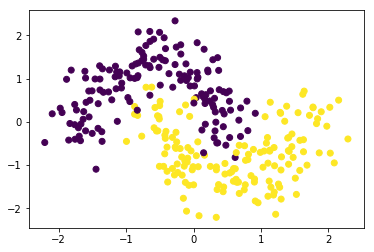

In [46]:
x,y = datasets.make_moons(n_samples = 300,noise = 0.2,random_state=42)
x = StandardScaler().fit_transform(x) # Scale to unit variance, no mean
plt.scatter(x[:,0],x[:,1],c=y)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

### Decision trees
A decision tree evaluates a series of questions, and uses this to trace a path through a binary tree. The resulting end node gives the prediction. Decision trees are trained by choosing a feature and threshold at each node that gives the most information. The training data is split according to this criteria and sent down to lower nodes until the max depth is reached (or if not specified, the node is pure - which I think means that it can exactly sort the training data with no error?)

Decision trees tend to badly overfit data

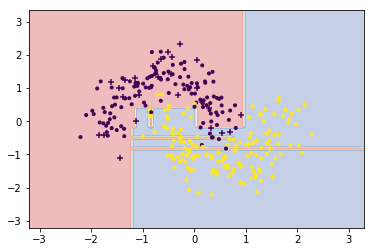

Train acc. 99.6 %
Test acc. 88.3 %


In [53]:
def print_accs(x_train,x_test,y_train,y_test,clf):
    test_acc = np.mean(y_test == clf.predict(x_test))
    train_acc = np.mean(y_train == clf.predict(x_train))
    print('Train acc. %0.1f %%' % (train_acc*100))
    print('Test acc. %0.1f %%' %(test_acc*100))

def plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf):
    
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu,alpha=0.3)
    plt.scatter(x_test[:,0],x_test[:,1],c=y_test,marker = '+')
    plt.scatter(x_train[:,0],x_train[:,1],c=y_train,marker = '.')
    plt.show()

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=8,random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)

### Random forests

The trick for dealing with overfitting of decision trees is basically to combine a bunch of them. The output (for a classification problem) is the mode of the outputs of each of the trees

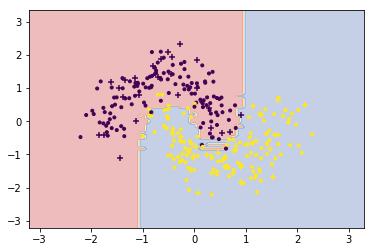

Train acc. 99.2 %
Test acc. 98.3 %


In [54]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(max_depth=8,n_estimators=10,random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)

Clearly less overfitting!

### AdaBoost

AdaBoost is another approach to using an ensemble of classifiers. This has a slightly different aim, which is to improve the accuracy of the prediction by combining a weight sum of classifiers in a targeted fashion. This means that it may reduce bias, but not necessarily overfitting.

Here we will take a lower depth decision tree classifier as our base tree, and combine them to improve accuracy using Adaboost.

So to start, here is an example of our base classifier:

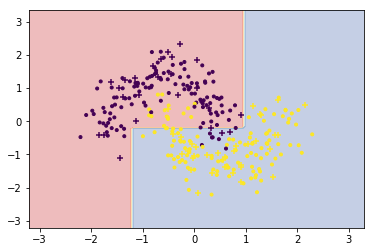

Train acc. 91.2 %
Test acc. 93.3 %


In [55]:
clf = tree.DecisionTreeClassifier(max_depth=3,random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)

Clearly a simple decision surface, but also low overfitting! Lets combine them

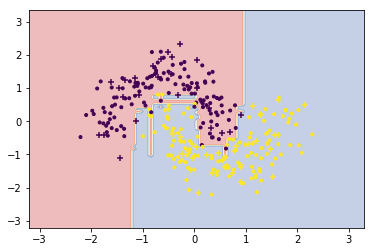

Train acc. 100.0 %
Test acc. 95.0 %


In [56]:
clf = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3),random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)

More accurate for both the test and train, although clearly overfitting still

### Support vector machine

A linear support vector machine is quite easy to understand - it tries to find a hyperplane that maximises the distance between the two classes. For overlapping classes, this is clearly impossible, and so it computes a soft equivalent in which the penalty scales with the distance to the separating hyperplanes.

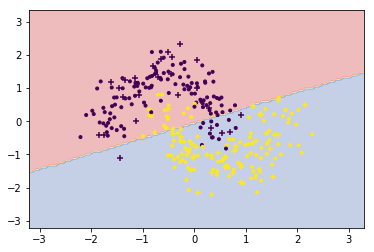

Train acc. 86.2 %
Test acc. 90.0 %


In [62]:
from sklearn.svm import SVC
clf = SVC(kernel='linear',random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)

The nonlinear kernel trick does the same thing, but in a space for which there is a nonlinear transformation from our space. The details of this I don't quite follow as of yet, but clearly it can work well:

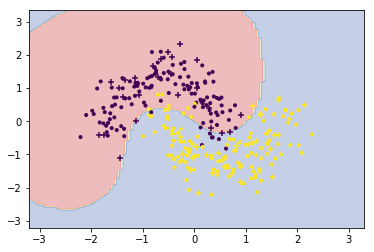

Train acc. 92.9 %
Test acc. 93.3 %


In [63]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf',random_state=42)
clf = clf.fit(x_train, y_train)

plot_decision_surface_and_points(x,x_train,y_train,x_test,y_test,clf)
print_accs(x_train,x_test,y_train,y_test,clf)